
# Predicció del Nutri-Score amb Machine Learning

Aquest notebook mostra el procés complet per predir el **Nutri-Score (A-E)** dels productes alimentaris utilitzant tècniques de machine learning amb Python.

##  Objectiu
Crear un model supervisat per predir el Nutri-Score d’un producte a partir de les seves característiques. Per evitar biaixos, s’han **exclòs variables relacionades directament amb el Nutri-Score**, com ara `Nutriscore` i `Calc_Eating_Healthy`.

## Llibreries utilitzades
- `pandas`, `numpy` per manipulació de dades
- `sklearn`, `xgboost` per modelatge
- `matplotlib`, `seaborn` per visualització


In [57]:
# Llibreries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# Carreguem les dades normalitzades anteriorment
df = pd.read_excel("products_quantities_normalized.xlsx")

# Codifiquem NutriScore a numeros per a poder despres mirar quan aprop estan les prediccions (eg. a - b estan aprop vs a - e vs e son  prediccions molt llunyanes)
df = df[df["Nutriscore"].notnull()]
df["NutriScore_numeric"] = df["Nutriscore"].map({"A":0, "B":1, "C":2, "D":3, "E":4})

In [59]:
# Seleccionem variables numèriques i booleanes amb >=100 valors, excloent les variables relacionades - eating healthy, nutriscore, calc eating healthy
numeric_cols = df.select_dtypes(include='number').columns
valid_numeric = [col for col in numeric_cols if df[col].notna().sum() >= 100]
binary_candidates = [col for col in df.columns if df[col].nunique() == 2 and df[col].notna().sum() >= 100]

# Combinem i excloem variables relacionades amb NutriScore
excluded = ['Nutriscore', 'NutriScore', 'NutriScore_numeric', 'Calc_Eating_Healthy']
features = sorted(set(valid_numeric + binary_candidates) - set(excluded))

# Files amb valors nuls
df = df[df["NutriScore_numeric"].notnull()].copy()
df[features] = df[features].fillna(-1)
X = df[features]
y = df["NutriScore_numeric"]

In [60]:
# Dividim les dades entre test i train 0.2 - 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"📊 Nombre d'elements en el conjunt d'entrenament: {len(X_train)}")
print(f"🧪 Nombre d'elements en el conjunt de test: {len(X_test)}")
print(f"Total inicial amb NutriScore: {len(df)}")
print(f"Nombre de files eliminades per tenir NaNs a les features: {df[features + ['NutriScore_numeric']].isna().any(axis=1).sum()}")


📊 Nombre d'elements en el conjunt d'entrenament: 9636
🧪 Nombre d'elements en el conjunt de test: 2410
Total inicial amb NutriScore: 12046
Nombre de files eliminades per tenir NaNs a les features: 0


In [61]:
# Models "Random Forest", "Gradient Boosting","XGBoost":
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss")
}
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "report": classification_report(y_test, y_pred, output_dict=True),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))


Model: Random Forest
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88       443
         1.0       0.89      0.70      0.79       378
         2.0       0.78      0.87      0.82       579
         3.0       0.85      0.82      0.83       477
         4.0       0.92      0.94      0.93       533

    accuracy                           0.85      2410
   macro avg       0.86      0.84      0.85      2410
weighted avg       0.86      0.85      0.85      2410


Model: Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       443
         1.0       0.84      0.63      0.72       378
         2.0       0.70      0.80      0.75       579
         3.0       0.78      0.81      0.79       477
         4.0       0.92      0.91      0.92       533

    accuracy                           0.81      2410
   macro avg       0.82      0.80      0.81      2410
weighted avg       0.81      

C:\Users\cescp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [22:23:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model: XGBoost
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       443
         1.0       0.88      0.74      0.81       378
         2.0       0.81      0.89      0.85       579
         3.0       0.87      0.84      0.86       477
         4.0       0.94      0.95      0.95       533

    accuracy                           0.88      2410
   macro avg       0.88      0.87      0.87      2410
weighted avg       0.88      0.88      0.88      2410



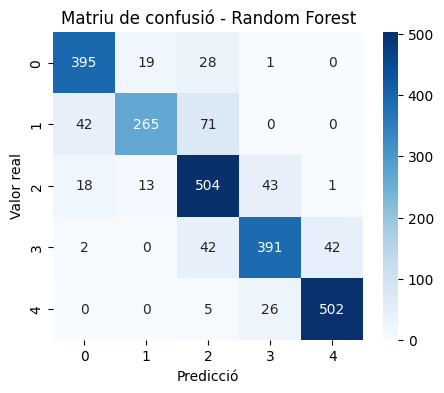

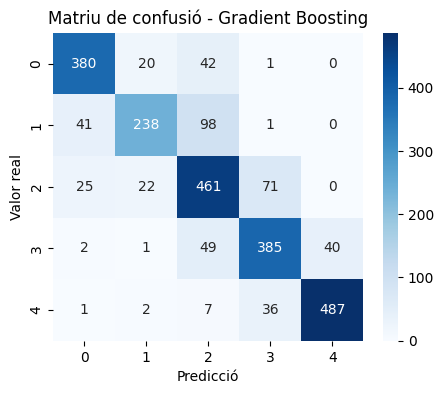

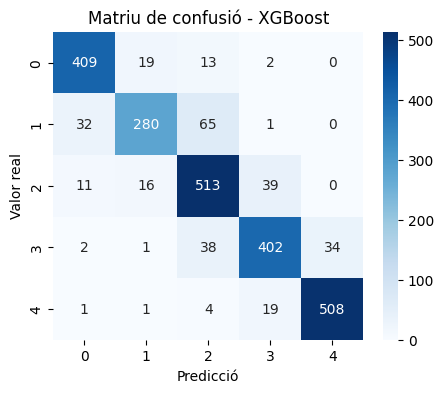

In [62]:
# Matrius de confusió
for name, res in results.items():
    plt.figure(figsize=(5,4))
    sns.heatmap(res["conf_matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriu de confusió - {name}")
    plt.xlabel("Predicció")
    plt.ylabel("Valor real")
    plt.show()

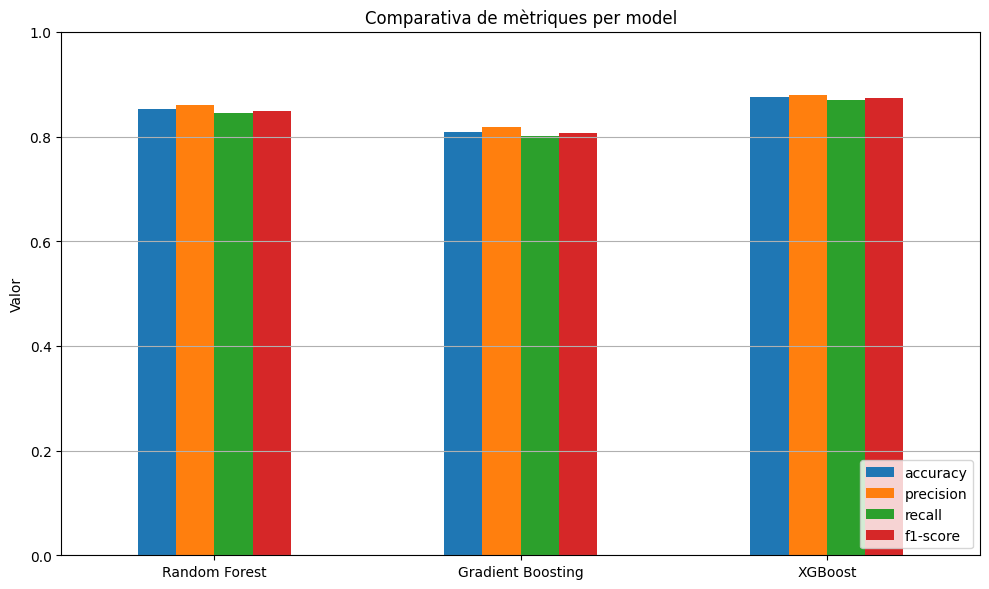

In [63]:
# Comparativa de les mètriques amb els 3 models
metrics_df = pd.DataFrame({
    name: {
        "accuracy": accuracy_score(y_test, res["y_pred"]),
        "precision": res["report"]["macro avg"]["precision"],
        "recall": res["report"]["macro avg"]["recall"],
        "f1-score": res["report"]["macro avg"]["f1-score"]
    } for name, res in results.items()
}).T

metrics_df.plot(kind="bar", figsize=(10,6))
plt.title("Comparativa de mètriques per model")
plt.ylabel("Valor")
plt.ylim(0,1)
plt.grid(axis="y")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

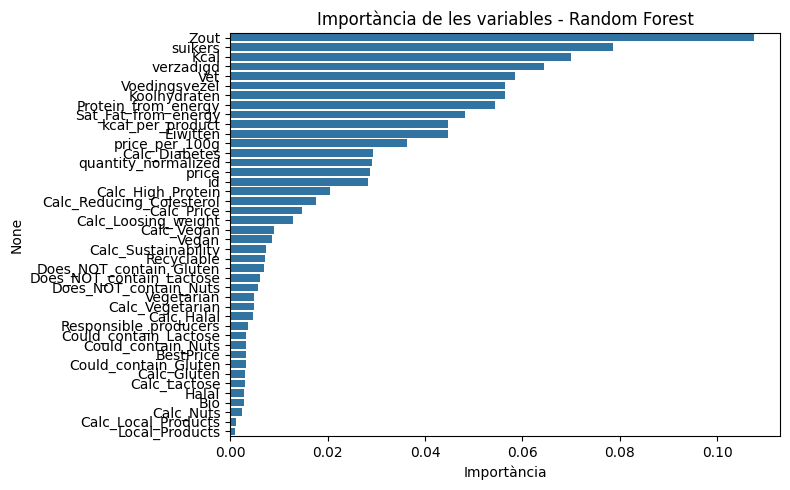

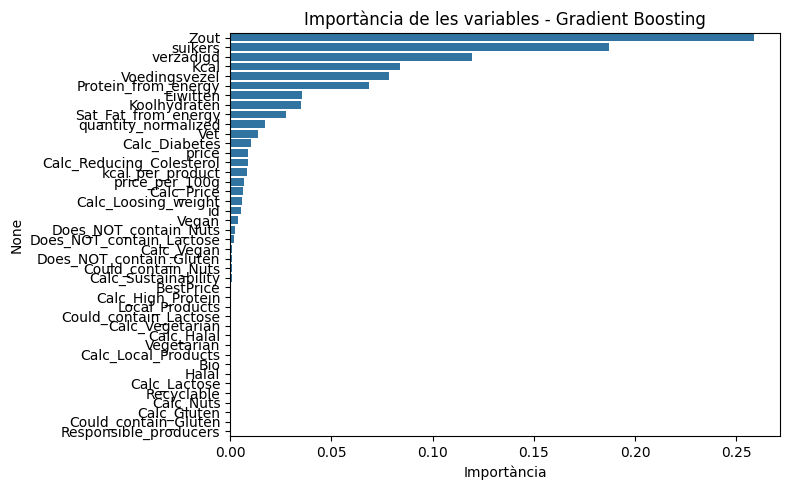

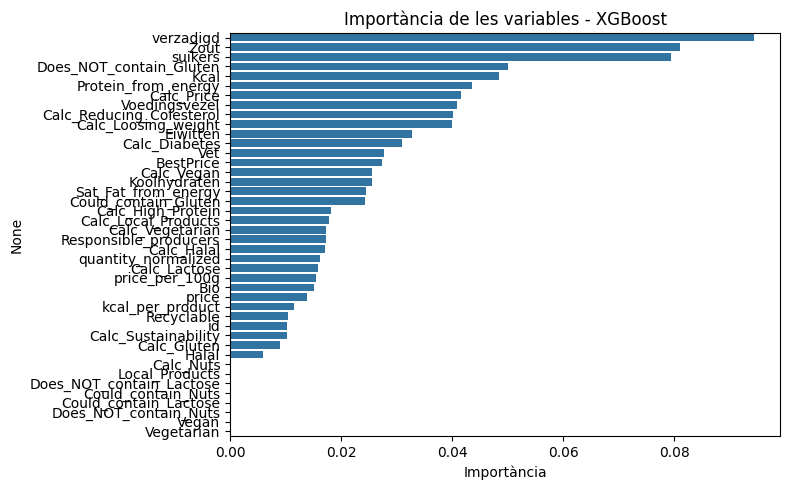

In [64]:
# Importancia de les variables
for name, res in results.items():
    model = res["model"]
    if hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
        plt.figure(figsize=(8,5))
        sns.barplot(x=importances.values, y=importances.index)
        plt.title(f"Importància de les variables - {name}")
        plt.xlabel("Importància")
        plt.tight_layout()
        plt.show()

In [65]:
import pandas as pd
import numpy as np
from collections import Counter

# Convertim les prediccions en DataFrame
votacions = pd.DataFrame({
    "RandomForest": results["Random Forest"]["model"].predict(X_test),
    "GradientBoosting": results["Gradient Boosting"]["model"].predict(X_test),
    "XGBoost": results["XGBoost"]["model"].predict(X_test)
})

# Funció per aplicar la lògica del 4t "model"
def vot_majoritari(row):
    comptador = Counter(row)
    if len(comptador) == 3:  # Tots diferents
        return row["XGBoost"]
    else:
        return comptador.most_common(1)[0][0]

# Aplicar votació
votacions["pred_majority"] = votacions.apply(vot_majoritari, axis=1)

# Avaluar
from sklearn.metrics import classification_report
print("Resultats de la predicció per votació majoritària:")
print(classification_report(y_test, votacions["pred_majority"]))


Resultats de la predicció per votació majoritària:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       443
         1.0       0.88      0.71      0.78       378
         2.0       0.79      0.88      0.83       579
         3.0       0.85      0.83      0.84       477
         4.0       0.93      0.94      0.94       533

    accuracy                           0.86      2410
   macro avg       0.87      0.85      0.86      2410
weighted avg       0.86      0.86      0.86      2410




## Avaluacio de la distància mitjana d'error (Mean Absolute Error)

Perquè Nutri-Score és una variable ordinal (A < B < C < D < E), no totes les prediccions incorrectes tenen el mateix impacte. Aquí calculem l'**error absolut mitjà (MAE)** per mesurar com n'està de lluny la predicció de la realitat.
    

In [66]:

from sklearn.metrics import mean_absolute_error

# Calcul de l'error mitjà absolut per cada model
mae_results = {
    "Random Forest": mean_absolute_error(y_test, results["Random Forest"]["y_pred"]),
    "Gradient Boosting": mean_absolute_error(y_test, results["Gradient Boosting"]["y_pred"]),
    "XGBoost": mean_absolute_error(y_test, results["XGBoost"]["y_pred"]),
    "Votació Majoritària": mean_absolute_error(y_test, votacions["pred_majority"])
}

# Mostrem resultats
mae_df = pd.DataFrame.from_dict(mae_results, orient='index', columns=['Mean Absolute Error']).sort_values("Mean Absolute Error")
display(mae_df)
    

,Mean Absolute Error
XGBoost,0.141494
Votació Majoritària,0.158921
Random Forest,0.170539
Gradient Boosting,0.227386


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import pandas as pd

# Define predictions
predictions = {
    "Random Forest": results["Random Forest"]["y_pred"],
    "Gradient Boosting": results["Gradient Boosting"]["y_pred"],
    "XGBoost": results["XGBoost"]["y_pred"],
    "Votació Majoritària": votacions["pred_majority"]
}

# Prepare comparison metrics
comparison_summary = {
    model: {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (macro)": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "F1-score (macro)": f1_score(y_test, y_pred, average="macro", zero_division=0),
        "Mean Absolute Error": mean_absolute_error(y_test, y_pred)
    }
    for model, y_pred in predictions.items()
}

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_summary).T.sort_values("F1-score (macro)", ascending=False)

# Display
print("Comparativa final dels models:")
display(comparison_df)


Comparativa final dels models:


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Mean Absolute Error
XGBoost,0.876349,0.879626,0.869173,0.872728,0.141494
Votació Majoritària,0.862241,0.867160,0.853796,0.858093,0.158921
Random Forest,0.853527,0.860246,0.844944,0.849637,0.170539
Gradient Boosting,0.809544,0.818488,0.800888,0.805992,0.227386



📊 **Interpretació**: Un valor més baix de MAE indica que el model tendeix a equivocar-se menys lluny del valor real de Nutri-Score. Aquest mètode penalitza més fortament els errors llunyans (per exemple, predir E quan era A).
    

<Figure size 1200x600 with 0 Axes>

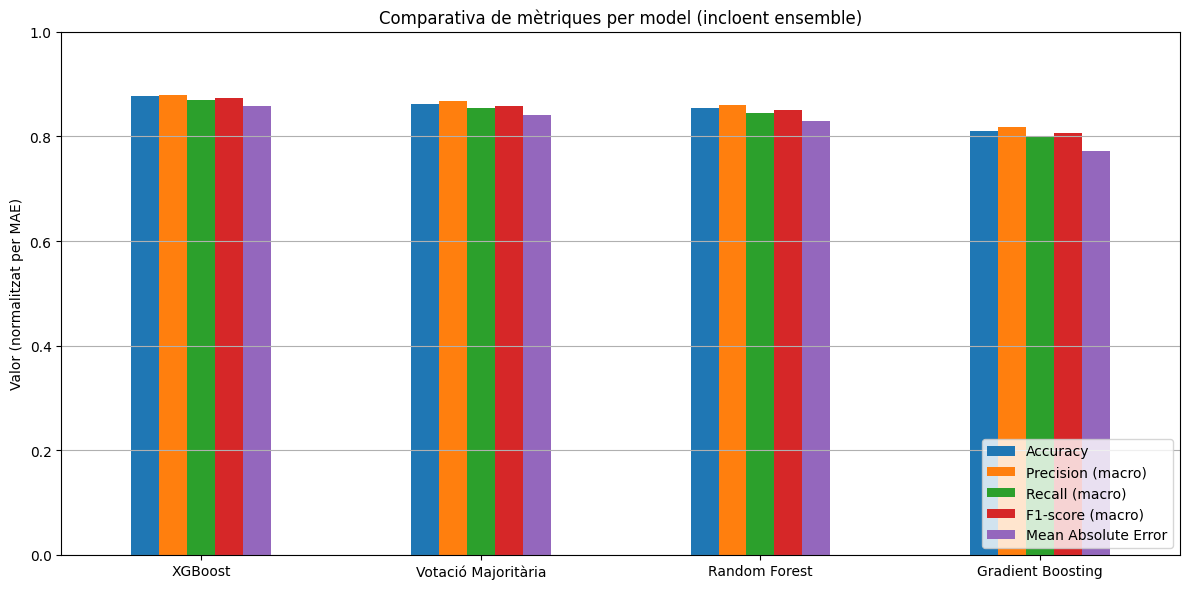

In [68]:
import matplotlib.pyplot as plt

#  Reutilitzem la taula de comparació
metrics_to_plot = ["Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)", "Mean Absolute Error"]

# 🔄 Normalitzem MAE (invertim valor perquè visualment “menys” és “millor”)
comparison_df_norm = comparison_df.copy()
comparison_df_norm["Mean Absolute Error"] = 1 - comparison_df_norm["Mean Absolute Error"]  # invertim per comparabilitat

# Plot
plt.figure(figsize=(12,6))
comparison_df_norm[metrics_to_plot].plot(kind="bar", figsize=(12,6))
plt.title("Comparativa de mètriques per model (incloent ensemble)")
plt.ylabel("Valor (normalitzat per MAE)")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.grid(axis="y")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [48]:
from collections import Counter

# Load full dataset
df_all = pd.read_excel("products_quantities_normalized.xlsx")

# Replace NaNs in features with -1 or appropriate value
df_all_features = df_all[features].fillna(-1)

# Predict using all trained models
df_all["Pred_RF"] = results["Random Forest"]["model"].predict(df_all_features)
df_all["Pred_GB"] = results["Gradient Boosting"]["model"].predict(df_all_features)
df_all["Pred_XGB"] = results["XGBoost"]["model"].predict(df_all_features)

# Voting + XGBoost fallback
def vot_majoritari(row):
    votes = [row["Pred_RF"], row["Pred_GB"], row["Pred_XGB"]]
    count = Counter(votes)
    if len(set(votes)) == 3:
        return row["Pred_XGB"]
    return count.most_common(1)[0][0]

df_all["Pred_Votacio"] = df_all.apply(vot_majoritari, axis=1)


# Define mapping back to letters
inverse_nutriscore_map = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E"}

# Map numeric predictions to letter format
df_all["Pred_RF"] = df_all["Pred_RF"].map(inverse_nutriscore_map)
df_all["Pred_GB"] = df_all["Pred_GB"].map(inverse_nutriscore_map)
df_all["Pred_XGB"] = df_all["Pred_XGB"].map(inverse_nutriscore_map)
df_all["Pred_Votacio"] = df_all["Pred_Votacio"].map(inverse_nutriscore_map)


# Export all
df_all[["id", "product_name", "Nutriscore", "Pred_RF", "Pred_GB", "Pred_XGB", "Pred_Votacio"]].to_excel("prediccions_per_tots_els_14000.xlsx", index=False)

print("✅ Exportat amb totes les prediccions per tots els productes.")


✅ Exportat amb totes les prediccions per tots els productes.
